<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/mobile2.png?raw=true" width=800 align="left"/>

# 실습 내용

- K-Fold Cross Validation을 사용해 모델의 성능을 예측합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [6]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

In [7]:
# 데이터 읽어오기
path = 'https://raw.githubusercontent.com/Jangrae/csv/master/mobile_cust_churn.csv'
data = pd.read_csv(path)

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [9]:
# 데이터 살펴보기
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,0,31953,0,6,313378,161,0,4,unsat,little,no,STAY
1,2,1,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
2,3,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
3,4,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
4,5,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY


**데이터 설명**

- COLLEGE: 대학 졸업여부
- INCOME: 연수입
- OVERAGE: 월평균 초과사용 시간(분)
- LEFTOVER: 월평균 잔여시간비율(%)
- HOUSE: 집값
- HANDSET_PRICE: 스마트폰 가격
- OVER_15MINS_CALLS_PER_MONTH: 월평균 장기통화(15분이상) 횟수
- AVERAGE_CALL_DURATION: 평균 통화 시간
- REPORTED_SATISFACTION: 만족도 설문조사 결과
- REPORTED_USAGE_LEVEL: 사용도 자가진단 결과
- CONSIDERING_CHANGE_OF_PLAN: 향후 변경계획 설문조사 결과
- CHURN: 이탈(번호이동) 여부 (Target 변수)

In [11]:
# 기술통계 확인
data.describe()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.502400,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250
std,5773.647028,0.500007,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558
min,1.000000,0.000000,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000
25%,5000.750000,0.000000,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000
50%,10000.500000,1.000000,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000
75%,15000.250000,1.000000,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000
max,20000.000000,1.000000,159983.000000,335.000000,89.000000,999996.000000,899.000000,29.000000,15.000000


# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) 변수 제거**

In [14]:
# 제거 대상: id

data.drop(columns='id' , inplace =True)
# 변수 제거


# 확인
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,0,31953,0,6,313378,161,0,4,unsat,little,no,STAY
1,1,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
2,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
3,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
4,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY


**2) x, y 분리**

In [16]:
# Target 설정
target= 'CHURN'

# 데이터 분리
x= data.drop(columns= target , axis=1)
y= data.loc[:,target]

**3) 가변수화**

In [18]:
# 가변수화 대상: REPORTED_SATISFACTION, REPORTED_USAGE_LEVEL, CONSIDERING_CHANGE_OF_PLAN
dumm_cols= [ 'REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']

# 가변수화
x =pd.get_dummies(x,columns=dumm_cols , drop_first=True)

# 확인
x.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,0,31953,0,6,313378,161,0,4,False,True,False,False,False,True,False,False,False,False,True,False
1,1,36147,0,13,800586,244,0,6,False,True,False,False,False,True,False,False,True,False,False,False
2,1,27273,230,0,305049,201,16,15,False,True,False,False,False,False,False,True,False,False,False,True
3,0,120070,38,33,788235,780,3,2,False,True,False,False,False,False,True,False,True,False,False,False
4,1,29215,208,85,224784,241,21,1,False,False,False,True,False,True,False,False,False,True,False,False


**4) 학습용, 평가용 데이터 분리**

In [20]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split


# 7:3으로 분리
x_train, x_test, y_train , y_test= train_test_split(x,y, test_size=0.3 , random_state= 1, stratify=y)

**5) 정규화**

In [22]:
# 모듈 불러오기
from sklearn.preprocessing import MinMaxScaler

# 정규화

scaler = MinMaxScaler()

x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)




# 4.성능 예측

- K분할 교차 검증 방법으로 모델 성능을 예측합니다.
- cross_val_score(model, x_train, y_train, cv=n) 형태로 사용합니다.
- cv 옵션에 k값(분할 개수, 기본값=5)을 지정합니다.
- cross_val_score 함수는 넘파이 배열 형태의 값을 반환합니다.
- cross_val_score 함수 반환 값의 평균을 해당 모델의 예측 성능으로 볼 수 있습니다.

**1) KNN**

In [25]:
# 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# 선언하기
model = KNeighborsClassifier(n_neighbors=3)

# 검증하기

cv_score = cross_val_score( model, x_train, y_train , cv=10)

# 확인
print(cv_score.mean())

# 저장

result={}

result['KNN']=cv_score.mean()

print(result)

0.5742857142857143
{'KNN': 0.5742857142857143}


**2) Decision Tree**

In [27]:
# 불러오기
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# 선언하기
model= DecisionTreeClassifier(max_depth=7)

# 검증하기
cv_score= cross_val_score(model, x_train, y_train , cv= 10)

# 확인
print(cv_score.mean())


# 저장



result['Decision Tree']=cv_score.mean()


0.693


**3) Logistic Regression**

In [29]:
# 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# 선언하기
model= LogisticRegression(max_iter= 5)

# 검증하기
cv_score= cross_val_score(model, x_train, y_train , cv= 10)

# 확인
print(cv_score.mean())


# 저장



result['Logistic Regression']=cv_score.mean()


0.5712142857142857


In [30]:
print(result)

{'KNN': 0.5742857142857143, 'Decision Tree': 0.693, 'Logistic Regression': 0.5712142857142857}


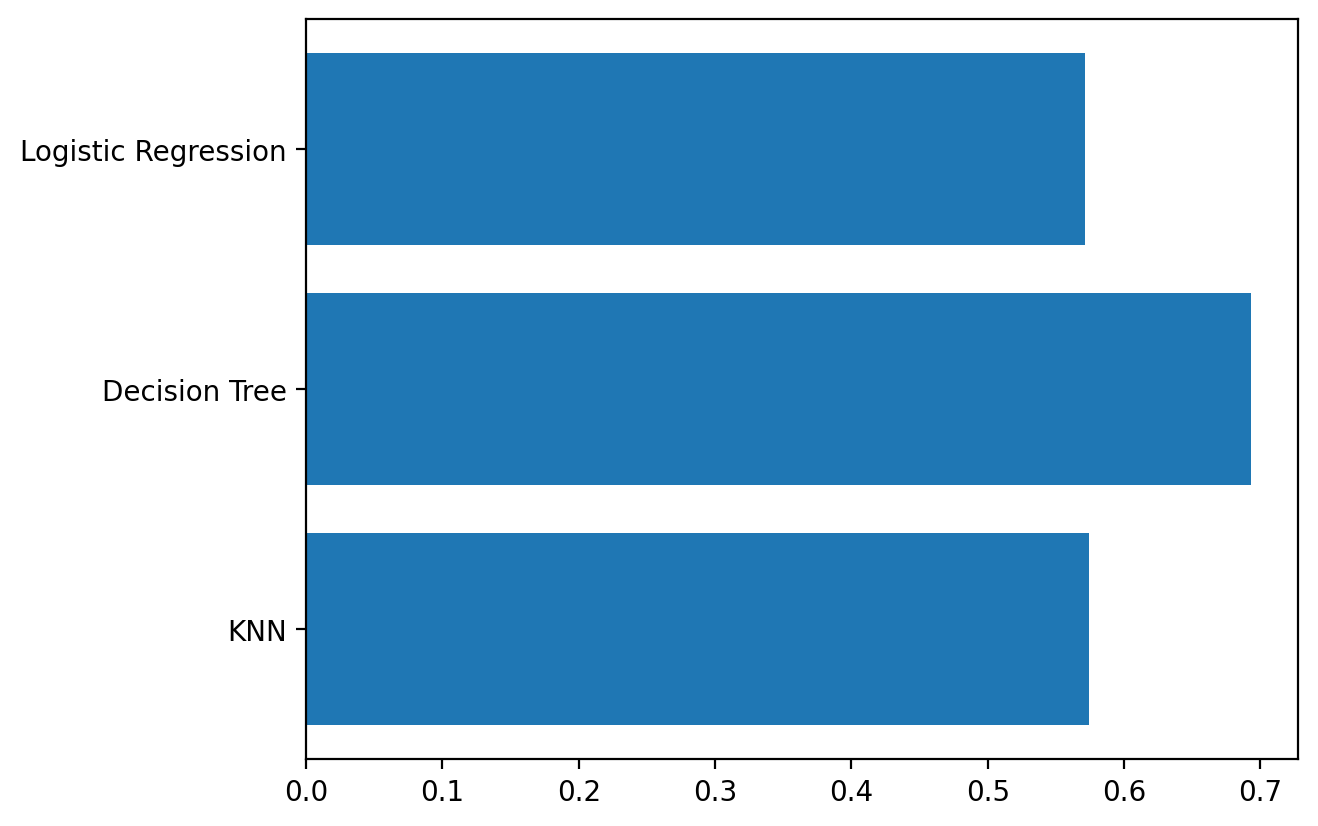

In [31]:
# 시각화
plt.barh(list(result),result.values())

plt.show()

In [32]:
# 예측 및 평가 수행
from sklearn.metrics import classification_report

model= LogisticRegression()

model.fit(x_train, y_train)
y_pred=model.predict(x_test)


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       LEAVE       0.62      0.62      0.62      2956
        STAY       0.63      0.63      0.63      3044

    accuracy                           0.62      6000
   macro avg       0.62      0.62      0.62      6000
weighted avg       0.62      0.62      0.62      6000

